In [1]:
#Installing libraries

import pandas as pd
!pip install datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast
import seaborn as sns

#Loading data

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#Data cleanup

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: C:\Users\zyesn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [2]:
df_da_us = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

In [3]:
df_da_us = df_da_us.dropna(subset='salary_year_avg')
df_da_us_exploded = df_da_us.explode('job_skills')

In [4]:
# grouping by job_skills, values = salary, split on count and median
df_da_skills = df_da_us_exploded.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count',ascending=False)
df_da_skills = df_da_skills.rename(columns={'count':'skill_count', 'median':'median_salary'})

In [5]:
#defining % of total job posting 
da_job_count = len(df_da_us)
df_da_skills['skill_percent'] = df_da_skills['skill_count'] / len(df_da_us) * 100

In [6]:
#filtering top5% skills
top_5pc_skills = df_da_skills[df_da_skills['skill_percent'] > 5]

In [7]:
top_5pc_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


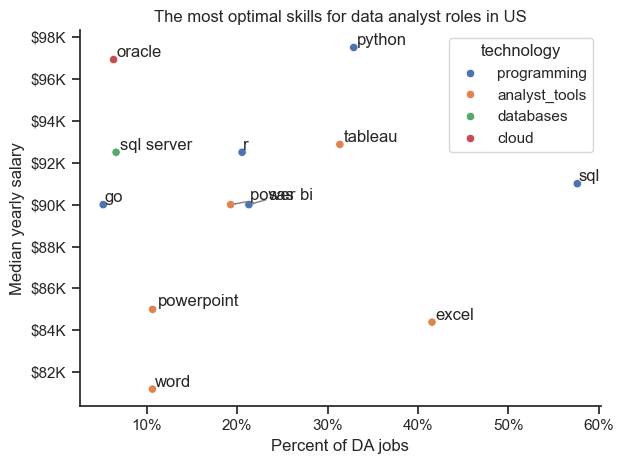

In [22]:
#plotting the result
from adjustText import adjust_text
#top_5pc_skills.plot(kind = 'scatter', x = 'skill_percent', y = 'median_salary')
sns.scatterplot(data=df_plot, x = 'skill_percent', y = 'median_salary', hue = 'technology')
sns.despine()
sns.set_theme(style='ticks')


#prepare text for adjust_text
texts = []

for index, text in enumerate(top_5pc_skills.index):
    texts.append(plt.text(top_5pc_skills['skill_percent'].iloc[index], top_5pc_skills['median_salary'].iloc[index], text))


adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'gray')) #using adjust_text module to prevent from text overlapping on the graph

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')) #formatting to getting $xxK numbers format
from matplotlib.ticker import PercentFormatter #importing percent formatter from matplotlib submodule to get % on axis
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))

plt.title('The most optimal skills for data analyst roles in US')
plt.xlabel('Percent of DA jobs')
plt.ylabel('Median yearly salary')
plt.tight_layout()
plt.show()

In [9]:
df_type_skills = df_da_us['job_type_skills'].copy()
df_type_skills = df_type_skills.drop_duplicates()
df_type_skills = df_type_skills.dropna()

In [10]:
technology_dict = {}

In [11]:
#combining all dictionaries into one
for row in df_type_skills:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

In [12]:
#removing duplicates by converting to set and then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [13]:
#creating a df from dict and exloding 'skills' column 
df_technology = pd.DataFrame(technology_dict.items(), columns=['technology','skills'])
df_technology = df_technology.explode('skills')

In [14]:
df_plot = top_5pc_skills.merge(df_technology, left_on='job_skills', right_on = 'skills')